## 1. Environment Setup and Libraries

In [ ]:
!pip install -q gdown

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

## 2. Data Loading

### 2.1. Download from Google Drive

In [ ]:
!gdown --folder 1JvI5xhPfN3VmjpWYZk9fCHG41xG697um -O finalterm_folder

Retrieving folder contents
Processing file 1ALveidCmKzk4p_liQ7b663BXL0PcTaFN test_transaction.csv
Processing file 1Ujh37a1kTarNf3dSOSrj-hKDswULebYA train_transaction.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1ALveidCmKzk4p_liQ7b663BXL0PcTaFN
From (redirected): https://drive.google.com/uc?id=1ALveidCmKzk4p_liQ7b663BXL0PcTaFN&confirm=t&uuid=803c5814-c264-4df2-b1ac-787e1d5dd668
To: /content/finalterm_folder/test_transaction.csv
100% 613M/613M [00:06<00:00, 95.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Ujh37a1kTarNf3dSOSrj-hKDswULebYA
From (redirected): https://drive.google.com/uc?id=1Ujh37a1kTarNf3dSOSrj-hKDswULebYA&confirm=t&uuid=cdd892c1-ca0b-4f8a-9270-cfc5e4ebca93
To: /content/finalterm_folder/train_transaction.csv
100% 683M/683M [00:09<00:00, 73.7MB/s]
Download completed


### 2.2. Load to Dataframe

In [ ]:
PATH = "finalterm_folder/"

train = pd.read_csv(PATH + 'train_transaction.csv')
test = pd.read_csv(PATH + 'test_transaction.csv')

print(f"Train Dataset: {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Test Dataset: {test.shape[0]} rows, {test.shape[1]} columns")

Train Dataset: 590540 rows, 394 columns
Test Dataset: 506691 rows, 393 columns


## 3. Data Preprocessing & Cleaning

### 3.1. Handling Missing Values

We first identify columns with too much missing data. If a column is 50% empty, it likely contains more noise than useful information. After dropping them, we fill the remaining gaps using the median for numbers and "Unknown" for text.

In [ ]:
# Identify columns with > 50% missing values in the train set
missing_threshold = 0.5
null_vars = train.isnull().sum() / len(train)
cols_to_drop = null_vars[null_vars > missing_threshold].index.tolist()

print(f"Dropping {len(cols_to_drop)} columns with high missing values...")

# Drop columns from both train and test sets
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

# Handle Numerical Missing Values
# Identify numerical columns (excluding the target 'isFraud' and 'TransactionID')
numerical_features = train.select_dtypes(exclude=['object']).columns.tolist()
if 'isFraud' in numerical_features:
    numerical_features.remove('isFraud')
if 'TransactionID' in numerical_features:
    numerical_features.remove('TransactionID')

imputer = SimpleImputer(strategy='median')

# Fit and transform the features
train[numerical_features] = imputer.fit_transform(train[numerical_features])
test[numerical_features] = imputer.transform(test[numerical_features])

# CONVERT isFraud TO INTEGER
train['isFraud'] = train['isFraud'].astype(int)

# Result Verification
print("-" * 30)
print(f"Target 'isFraud' type: {train['isFraud'].dtype}")
print(f"Missing values in train: {train.isnull().sum().sum()}")
print(f"Missing values in test: {test.isnull().sum().sum()}")
print("-" * 30)

# Display the first few rows to verify the stages
train.head()

Dropping 174 columns with high missing values...
------------------------------
Target 'isFraud' type: int64
Missing values in train: 1361708
Missing values in test: 1001886
------------------------------


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400.0,68.5,W,13926.0,361.0,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401.0,29.0,W,2755.0,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469.0,59.0,W,4663.0,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499.0,50.0,W,18132.0,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506.0,50.0,H,4497.0,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2. Categorical Encoding

Machine Learning models only understand numbers. We convert categorical columns (like ProductCD or card4) into numerical labels.

In [ ]:
# Identify categorical columns
cat_cols = train.select_dtypes(include=['object']).columns
print(f"Encoding categorical columns: {list(cat_cols)}")

for col in cat_cols:
    # Fill categorical NaNs with 'Unknown'
    train[col] = train[col].fillna('Unknown')
    test[col] = test[col].fillna('Unknown')

    # Apply Label Encoding
    le = LabelEncoder()
    # We combine train and test unique values to ensure consistent encoding
    full_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(full_data)

    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# Show result: Check data types
print("-" * 30)
print("Data types after encoding:")
print(train[cat_cols].dtypes.head())
print("-" * 30)
train[cat_cols].head()

Encoding categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M6']
------------------------------
Data types after encoding:
ProductCD        int64
card4            int64
card6            int64
P_emaildomain    int64
M1               int64
dtype: object
------------------------------


,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M6
0,4,2,2,0,1,1,1,2,1
1,4,3,2,17,2,2,2,0,1
2,4,4,3,36,1,1,1,0,0
3,4,3,3,55,2,2,2,0,0
4,1,3,2,17,2,2,2,3,2


### 3.3. Data Splitting and Feature Scaling

We isolate the target variable isFraud and split the data. We also scale the features so that columns with large numbers (like TransactionAmt) don't overpower smaller ones.

In [ ]:
# Define features (X) and target (y)
X = train.drop(columns=['isFraud', 'TransactionID'])
y = train['isFraud']
X_test_final = test.drop(columns=['TransactionID'])

# Ensure X and X_test_final have the same columns
X_test_final = X_test_final[X.columns]

# Split into 80% Train and 20% Validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print(f"Shape of X_train: {X_train_scaled.shape}")
print(f"Fraud distribution in Training set:\n{y_train.value_counts(normalize=True)}")

Shape of X_train: (472432, 218)
Fraud distribution in Training set:
isFraud
0    0.965011
1    0.034989
Name: proportion, dtype: float64


## 4. Modelling

### 4.1. Hyperparameter Tuning

We perform a "basic level" tuning using RandomizedSearchCV to find the best settings for our Random Forest.

In [ ]:
# Define a grid for basic tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_leaf': [2, 5]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Randomized Search (faster than GridSearchCV)
tune_model = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=3, cv=3, scoring='roc_auc', random_state=42)
tune_model.fit(X_train_scaled, y_train)

best_rf = tune_model.best_estimator_
print(f"Best Parameters found: {tune_model.best_params_}")

Best Parameters found: {'n_estimators': 100, 'min_samples_leaf': 2, 'max_depth': 20}


### 4.2. Evaluation & Confusion Matrix

We check how well the model predicts the validation set. We use a Confusion Matrix to see how many fraud cases were correctly caught vs. how many were missed.

In [ ]:
# Predictions
y_prob = best_rf.predict_proba(X_val_scaled)[:, 1]
y_pred = best_rf.predict(X_val_scaled)

print(f"Final ROC-AUC Score: {roc_auc_score(y_val, y_prob):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))

Final ROC-AUC Score: 0.9250
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    113975
           1       0.45      0.63      0.52      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.80      0.75    118108
weighted avg       0.97      0.96      0.96    118108



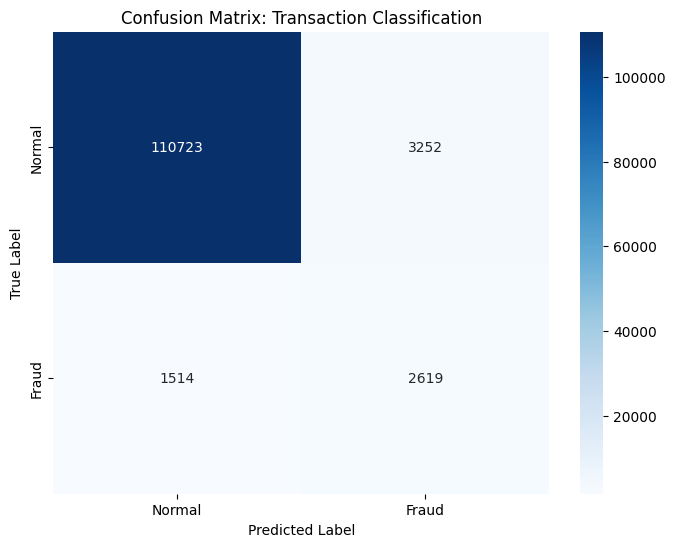

In [ ]:
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Transaction Classification')
plt.show()

### 4.3. Prediction

In [ ]:
# Prediction
test_probabilities = best_rf.predict_proba(X_test_scaled)[:, 1]

# Make dataframe for prediction
prediction = pd.DataFrame({
    'TransactionID': test['TransactionID'].astype(int),
    'isFraud': test_probabilities
})

prediction

,TransactionID,isFraud
0,3663549,0.079797
1,3663550,0.084607
2,3663551,0.082142
3,3663552,0.060291
4,3663553,0.043677
...,...,...
506686,4170235,0.198329
506687,4170236,0.073914
506688,4170237,0.222038
506689,4170238,0.248399
